# Exploring ship echosounder data from the Pacific Hake survey

Jupyter notebook accompanying the manuscript:

_Echopype: Interoperable and scalable echosounder data processing with Echopype_  
_Authors: Wu-Jung Lee, Landung Setiawan, Caesar Tuguinay, Emilio Mayorga, and Valentina Staneva_

## Introduction

### Description

This notebook uses a small subset of the EK60 echosounder data collected during the [2017 Joint U.S.-Canada Integrated Ecosystem and Pacific Hake Acoustic Trawl Survey (aka the "Hake survey")](https://www.fisheries.noaa.gov/west-coast/science-data/joint-us-canada-integrated-ecosystem-and-pacific-hake-acoustic-trawl-survey) to illustrate how data processed from echosounder can be easily used with functions from core scientific Python software packages. Here, we use [Xarray](https://docs.xarray.dev/en/stable/) and [GeoPandas](https://geopandas.org/en/stable/) to access and organize the ship position (GPS) data embedded in the echosounder dataset, and in turn use the ship track to slice (select) the echo data for plotting.

### Outline

1. Connect with AWS S3 bucket and generate a list of target echosounder `RAW` files
2. Convert, calibrate, regrid, and save echosounder data as Zarr stores on disk
3. Extract and organize ship GPS data from the `Platform` group of the Zarr stores
4. Slice and plot echo data based selected ship track segments

### Running the notebook

This notebook can be run with a conda environment created using the conda environment file https://github.com/OSOceanAcoustics/echopype-examples/blob/main/conda/environment-ep-main.yml. The notebook creates a directory, if not already present: `./exports/ship_track`. All Zarr files will be exported there.

### Note
We encourage importing `echopype` as `ep` for consistency.

<!-- ### Goals

- Illustrate a common workflow for echosounder data conversion, calibration and use. This workflow leverages the standardization applied by echopype and the power, ease of use and familiarity of libraries in the scientific Python ecosystem. 
- Extract and visualize data with relative ease using geospatial and temporal filters. 

### Description

This notebook uses EK60 echosounder data collected during the [2017 Joint U.S.-Canada Integrated Ecosystem and Pacific Hake Acoustic Trawl Survey ('Pacific Hake Survey')](https://www.fisheries.noaa.gov/west-coast/science-data/joint-us-canada-integrated-ecosystem-and-pacific-hake-acoustic-trawl-survey) to illustrate a common workflow for data conversion, calibration and analysis using [`echopype`](https://echopype.readthedocs.io) and core scientific Python software packages, particularly `xarray`, `GeoPandas`, `pandas` and `NumPy`. 

Two days of cloud-hosted `.raw` data files are accessed by echopype directly from an [Amazon Web Services (AWS)](https://aws.amazon.com/) S3 "bucket" maintained by the [NOAA NCEI Water-Column Sonar Data Archive](https://registry.opendata.aws/ncei-wcsd-archive/). The total data used are 170 `.raw` files at approximately 25 MB each (1 Hz pinging rate from first light to dusk), corresponding to approximately 4.2 GB. With `echopype`, each file is converted to a standardized representation based on the [SONAR-netCDF4 v1.0 convention](https://github.com/ices-publications/SONAR-netCDF4/) and saved to the cloud-optimized [Zarr](https://zarr.readthedocs.io) format. 

Data stored in the netCDF-based SONAR-netCDF4 convention can be conveniently and intuitively manipulated with `xarray` in combination with related scientific Python packages. [Mean Volume Backscattering Strength (MVBS)](http://www.fao.org/3/X5818E/x5818e07.htm) is computed with `echopype` from each raw data file and exported to a netCDF file. Here, we define two geographical bounding boxes encompassing two ship tracks and use these to extract corresponding timestamp intervals from the GPS data, and then the corresponding MVBS data based on those intervals. Finally, these extracted MVBS subsets are plotted as track echograms.

### Outline

1. Establish AWS S3 file system connection and generate list of target EK60 `.raw` files
2. Process S3-hosted raw files with `echopype`: convert, calibrate and export to standardized files
3. Extract and process GPS locations from the `Platform` group of converted raw files
4. Read MVBS and plot track echograms for time periods corresponding to two ship tracks

### Running the notebook

This notebook can be run with a conda environment created using the conda environment file https://github.com/OSOceanAcoustics/echopype-examples/blob/main/binder/environment.yml. The notebook creates two directories, if not already present: `./exports/cruisetrack_notebook_outputs/converted_zarr` and `./exports/cruisetrack_notebook_outputs/calibrated_nc`. Zarr and netCDF files will be exported there.

### Note
We encourage importing `echopype` as `ep` for consistency. -->

In [76]:
from pathlib import Path

import fsspec
import geopandas as gpd
import xarray as xr
from tqdm import tqdm

import matplotlib.pyplot as plt
from shapely.geometry import box
import cartopy.crs as ccrs
import cartopy.io.img_tiles as cimgt
from cartopy.mpl.gridliner import LONGITUDE_FORMATTER, LATITUDE_FORMATTER

import echopype as ep
from echopype.qc import exist_reversed_time

import warnings
warnings.simplefilter("ignore", category=DeprecationWarning)

## Setup

### Path setup
Set paths and create directories to store Zarr files:

In [77]:
output_path = Path("./exports/ship_track")
output_path.mkdir(exist_ok=True, parents=True)

echodata_zarr_path = output_path / "echodata_zarr"
echodata_zarr_path.mkdir(exist_ok=True)
Sv_zarr_path = output_path / "Sv_zarr"
Sv_zarr_path.mkdir(exist_ok=True)
MVBS_zarr_path = output_path / "MVBS_zarr"
MVBS_zarr_path.mkdir(exist_ok=True)

## Processing echosounder data

Below we loop through all target `.raw` files to convert, calibrate, and regrid the data to generate mean volume backscattering strength (MVBS). We save intermediate data products to disk to enable out-of-core computation (when the computation may require resources larger than the system memory).

### Identify target echosounder data files

Here, we access the public [NOAA Water-Column Sonar Data Archive S3 bucket](https://registry.opendata.aws/ncei-wcsd-archive/) via the [fsspec](https://filesystem-spec.readthedocs.io) file system interface, to identify a list of EK60 `.raw` files to be processed in this notebook.

In [78]:
fs = fsspec.filesystem('s3', anon=True)

bucket = "ncei-wcsd-archive"
raw_path = "data/raw/Bell_M._Shimada/SH1707/EK60"

In [79]:
raw_files = fs.glob(f"{bucket}/{raw_path}/*.raw")

# print out the last two S3 raw file paths in the list for verification
raw_files[-2:]

['ncei-wcsd-archive/data/raw/Bell_M._Shimada/SH1707/EK60/Summer2017-D20170913-T180733.raw',
 'ncei-wcsd-archive/data/raw/Bell_M._Shimada/SH1707/EK60/Winter2017-D20170615-T002629.raw']

Generate list of target EK60 `.raw` files from AWS S3 bucket based on dates from July 28-29, 2017.

In [80]:
raw_files = [
    s3path for s3path in raw_files 
    if any([f"D2017{datestr}" in s3path for datestr in ['0728', '0729']])
]

print(f"There are {len(raw_files)} target raw files available")

There are 170 target raw files available


In [81]:
raw_files[0]

'ncei-wcsd-archive/data/raw/Bell_M._Shimada/SH1707/EK60/Summer2017-D20170728-T000534.raw'

In [82]:
def populate_metadata(ed, raw_fname):
    """
    Populate metadata about the dataset and survey platform
    into the EchoData object.
    """
    
    # -- SONAR-netCDF4 Top-level Group attributes
    survey_name = (
        "2017 Joint U.S.-Canada Integrated Ecosystem and "
        "Pacific Hake Acoustic Trawl Survey (the 'Hake survey')"
    )
    ed['Top-level'].attrs['title'] = f"{survey_name}, file {raw_fname}"
    ed['Top-level'].attrs['summary'] = (
        f"EK60 raw file {raw_fname} from the {survey_name}, "
        "converted to SONAR-netCDF4 using Echopype."
        "Information about the survey program is available at "
        "https://www.fisheries.noaa.gov/west-coast/science-data/"
        "joint-us-canada-integrated-ecosystem-and-pacific-hake-acoustic-trawl-survey"
    )

    # -- SONAR-netCDF4 Platform Group attributes
    # Per SONAR-netCDF4, for platform_type see https://vocab.ices.dk/?ref=311
    ed['Platform'].attrs['platform_type'] = "Research vessel"
    ed['Platform'].attrs['platform_name'] = "Bell M. Shimada"  # A NOAA ship
    ed['Platform'].attrs['platform_code_ICES'] = "315"

### Convert and calibrate echo data

Depending on your internet speed, this cell below may take some time to run (potentially 20-30 mins).

In [12]:
%%time

for rf in raw_files:
    raw_fpath = Path(rf)
    try:
        # Access file directly from S3 to create a converted EchoData object in memory
        ed = ep.open_raw(
            f"s3://{rf}",
            sonar_model="EK60",
            use_swap=True,
            storage_options={"anon": True}
        )
        # Populate additional metadata
        populate_metadata(ed, raw_fpath.name)

        # Save to the converted EchoData object to Zarr on disk
        ed.to_zarr(save_path=echodata_zarr_path, overwrite=True)

        # Calibrate raw backscatter measurement to Sv 
        ds_Sv = ep.calibrate.compute_Sv(ed)

        # Add depth to the Sv dataset
        ds_Sv = ep.consolidate.add_depth(ds_Sv, depth_offset=9.15)

        # Save Sv dataset to Zarr on disk
        ds_Sv.to_zarr(Sv_zarr_path / f"{raw_fpath.stem}_Sv.zarr", mode="w")

    except Exception as e:
        print(f"Failed to process raw file {raw_fpath.name}: {e}")

CPU times: user 5min, sys: 1min 47s, total: 6min 47s
Wall time: 10min 16s


Below we regrid Sv data by computing mean volume backscattering strength (MVBS), which are binned averages of Sv (in the linear domain) across ping time and depth. Note that we take extra care in slicing the combined Sv store so that the `ping_time` intervals does not overlap for successive MVBS bins.

**Note**: The workflow here differs from those in the other two notebooks that also use the 2017 Hake survey data (`hake_NASC_EK60.ipynb`, `krill_NASC_EK60.ipynb`), in which the individual converted `EchoData` objects are combined via the `combine_echodata` first before calibration and regridding. We show this workflow variant here to demonstrate the flexibility of using Echopype functions.

### Regrid echo data

In [115]:
%%time

# Grab and sort Sv zarr paths
Sv_zarr_path_list = list(Sv_zarr_path.glob('*.zarr'))
Sv_zarr_path_list.sort()

# Initialize leftover ds_Sv zarr as None
leftover_ds_Sv = None

# Iterate through all Sv Zarr Paths
for file_path in Sv_zarr_path_list:
    # Open ds_Sv from disk Zarr
    ds_Sv = xr.open_zarr(file_path)

    # Concat leftover Sv with current Sv
    if leftover_ds_Sv is not None:
        concat_ds_Sv = xr.concat([leftover_ds_Sv, ds_Sv], dim="ping_time")
    else:
        concat_ds_Sv = ds_Sv
    
    # Resample data into 20-second bins
    resampled_data = concat_ds_Sv.resample(ping_time="20s", skipna=True)

    # Determine the start index of the last incomplete 20-second bin
    cutoff_index = max(group.start for group in resampled_data.groups.values())

    # Split data into complete and incomplete bins:

    # Take data up to the last complete bin
    complete_bins_Sv = concat_ds_Sv.isel(ping_time=slice(0, cutoff_index))

    # Keep remaining data for next iteration
    leftover_bin_Sv = concat_ds_Sv.isel(ping_time=slice(cutoff_index, -1))

    # Compute MVBS on current subset
    ds_MVBS = ep.commongrid.compute_MVBS(
        complete_bins_Sv,
        range_var="depth",
        range_bin='5m',  # in meters
        ping_time_bin='20s',  # in seconds
    )

    # Save MVBS dataset to Zarr on disk
    ds_MVBS.to_zarr(MVBS_zarr_path / f"{file_path.stem.replace('Sv', 'MVBS')}.zarr", mode="w")

CPU times: user 5min 15s, sys: 1min 58s, total: 7min 13s
Wall time: 6min 32s


### Test for time reversals

Small time reversals are sometimes found in EK60 datasets, where some `ping_time` (or GPS `time1`) value may be lower (older) than the preceding `ping_time`. Such discontinuities can interfere with concatenating data from individual files to produce an aggregated dataset. This issues can be identified and addressed by functions in the `echopype.qc` subpackage.

In [116]:
for filepath in echodata_zarr_path.glob('*.zarr'):
    ed = ep.open_converted(filepath)
    # Test for a negative ping_time increment in sequential timestamps, in the Sonar/Beam_group1 group
    if exist_reversed_time(ds=ed['Sonar/Beam_group1'], time_name='ping_time'):
        print(f'Reversed time in {filepath}')

There are no time reversals in this two-day dataset, fortunately.

## Extract and process GPS locations

Below we will use the Xarray `open_mfdataset` function to open and concatenate data from the `Platform` group from all converted `EchoData` Zarr stores, then assemble the GPS data (timestamp, latitude, and longitude) into a [GeoPandas](https://geopandas.org/) `GeoDataFrame` containing point-geometry objects. Note that `GeoDataFrame` adds geospatial capabilities to regular Pandas `DataFrame`.

Due to the presence of multiple time coordinates in the `Platform` group, we are careful in the argument passed to `open_mfdataset` to ensure the catenation for different variables is along the right coordinates.

In [99]:
%%time
ds_platform = xr.open_mfdataset(
    str(echodata_zarr_path / '*.zarr'), group='Platform', 
    engine='zarr',
    data_vars='minimal', coords='minimal',
    combine='nested',
    chunks='auto',
)

CPU times: user 46.6 s, sys: 2.1 s, total: 48.7 s
Wall time: 49.5 s


In [101]:
ds_platform

<xarray.Dataset> Size: 11MB
Dimensions:              (channel: 3, time1: 244846, time2: 88959)
Coordinates:
  * channel              (channel) <U37 444B 'GPT  18 kHz 009072058c8d 1-1 ES...
  * time1                (time1) datetime64[ns] 2MB 2017-07-28T00:05:36.10331...
  * time2                (time2) datetime64[ns] 712kB 2017-07-28T00:05:34.897...
Data variables: (12/20)
    MRU_offset_x         float64 8B nan
    MRU_offset_y         float64 8B nan
    MRU_offset_z         float64 8B nan
    MRU_rotation_x       float64 8B nan
    MRU_rotation_y       float64 8B nan
    MRU_rotation_z       float64 8B nan
    ...                   ...
    sentence_type        (time1) object 2MB dask.array<chunksize=(244846,), meta=np.ndarray>
    transducer_offset_x  (channel) float64 24B dask.array<chunksize=(3,), meta=np.ndarray>
    transducer_offset_y  (channel) float64 24B dask.array<chunksize=(3,), meta=np.ndarray>
    transducer_offset_z  (channel) float64 24B dask.array<chunksize=(3,), meta=np.ndarray>
    vertical_offset      (time2) float64 712kB dask.array<chunksize=(88959,), meta=np.ndarray>
    water_level          float64 8B 9.15
Attributes:
    platform_code_ICES:  315
    platform_name:       Bell M. Shimada
    platform_type:       Research vessel

We can use `time1` (the timestamps for NMEA datagrams, or GPS timestamps) to examine the exact timestamp interval spanned by the combined dataset.

In [102]:
print(f"{ds_platform.time1.values.min()}, {ds_platform.time1.values.max()}")

2017-07-28T00:05:36.103315000, 2017-07-30T00:17:59.381813000


To organize the GPS data, we first create a Pandas `DataFrame` and then turn it into a GeoPandas `GeoDataFrame`.

In [103]:
df_gps = ds_platform.latitude.to_dataframe().join(ds_platform.longitude.to_dataframe())

df_gps.head(3)

,latitude,longitude
time1,,
2017-07-28 00:05:36.103315,43.533072,-124.683998
2017-07-28 00:05:37.511097,43.533080,-124.684005
2017-07-28 00:05:37.669428,43.533167,-124.684000


In [104]:
gdf_gps = gpd.GeoDataFrame(
    df_gps,
    geometry=gpd.points_from_xy(df_gps['longitude'], df_gps['latitude']), 
    crs="epsg:4326"
)

Now we can generate a simple map plot of the point `GeoDataFrame`

<Axes: >

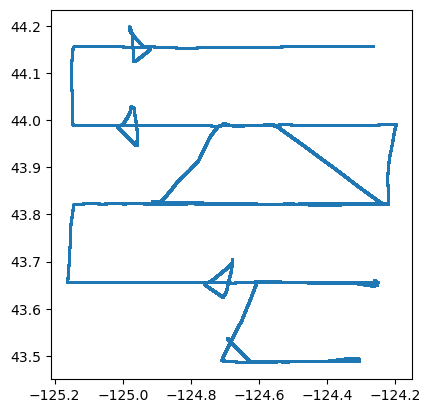

In [105]:
gdf_gps.plot(markersize=0.5)

## Slice and plot echo data based selected ship track segments

### Read all MVBS Zarr stores as a single dataset

Here we use the Xarray `open_mfdataset` function again to read all MVBS Zarr stores as a single dataset:

In [117]:
%%time
ds_MVBS = xr.open_mfdataset(
    str(MVBS_zarr_path / '*_MVBS.zarr'), 
    data_vars='minimal', coords='minimal',
    combine='by_coords',
    engine="zarr",
)

CPU times: user 2.26 s, sys: 68.7 ms, total: 2.33 s
Wall time: 2.32 s


Replace the `channel` dimension and coordinate with the `frequency_nominal` variable containing actual frequency values. Note that this step is possible only because there are no duplicated frequencies present.

In [118]:
ds_MVBS = ep.consolidate.swap_dims_channel_frequency(ds_MVBS)
ds_MVBS

<xarray.Dataset> Size: 32MB
Dimensions:            (frequency_nominal: 3, ping_time: 8649, depth: 152)
Coordinates:
  * frequency_nominal  (frequency_nominal) float64 24B 1.8e+04 3.8e+04 1.2e+05
  * depth              (depth) float64 1kB 0.0 5.0 10.0 ... 745.0 750.0 755.0
  * ping_time          (ping_time) datetime64[ns] 69kB 2017-07-28T00:05:20 .....
Data variables:
    Sv                 (frequency_nominal, ping_time, depth) float64 32MB dask.array<chunksize=(3, 59, 152), meta=np.ndarray>
    channel            (frequency_nominal) <U37 444B 'GPT  18 kHz 009072058c8...
Attributes:
    processing_function:          commongrid.compute_MVBS
    processing_software_name:     echopype
    processing_software_version:  0.8.2.dev206+g743413b
    processing_time:              2024-07-30T00:00:10Z

### Extract MVBS along two N-S tracks

Below, we define two rectangular bounding boxes to extract two North-South-oriented ship track segments, then plot all GPS locations (red) and the bounding boxes (black) on a map. 

We also plot the location of an OOI mooring (yellow star) from which the echosounder data is used in the eclipse notebook (`OOI_eclipse.ipynb`) in this repository.

In [119]:
tracksouth_bbox = gpd.GeoSeries(box(-125.17, 43.65, -125.14, 43.84), crs=gdf_gps.crs)
tracknorth_bbox = gpd.GeoSeries(box(-125.17, 43.98, -125.14, 44.17), crs=gdf_gps.crs)

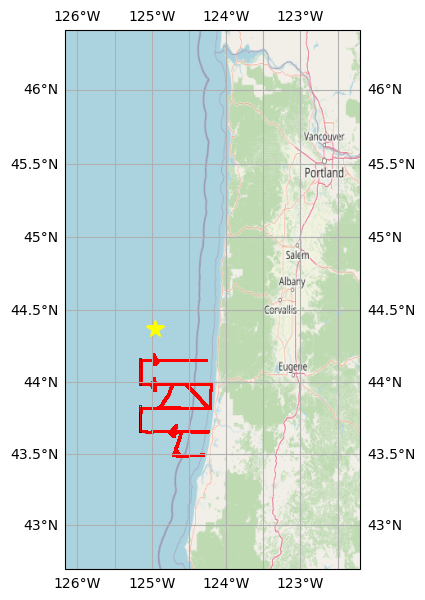

In [120]:
basemap = cimgt.OSM()

_, ax = plt.subplots(
    figsize=(9, 7), subplot_kw={"projection": basemap.crs}
)
bnd = gdf_gps.geometry.bounds
ax.set_extent([bnd.minx.min() - 1, bnd.maxx.max() + 2, 
               bnd.miny.min() - 0.8, bnd.maxy.max() + 2.2])
ax.add_image(basemap, 7)
ax.gridlines(draw_labels=True, xformatter=LONGITUDE_FORMATTER, yformatter=LATITUDE_FORMATTER)

# GPS points
gdf_gps.plot(ax=ax, markersize=0.1, color='red', 
             transform=ccrs.PlateCarree())

# Bounding box for selected tracks
tracksouth_bbox.plot(ax=ax, edgecolor="black", linewidth=0.5, facecolor='none', 
                     transform=ccrs.PlateCarree())
tracknorth_bbox.plot(ax=ax, edgecolor="black", linewidth=0.5, facecolor='none', 
                     transform=ccrs.PlateCarree())

# OOI CE04 Oregon Offshore mooring location
plt.plot(-124.95, 44.37, marker='*', color='yellow', markersize=13, 
         transform=ccrs.PlateCarree());

Now we can clip the `GeoDataFrame` using the bounding boxes to extract the timestamps of the two North-South ship track segments (along the `time1` coordinate), then use these timestamps to slice out MVBS datasets corresponding to these two ship track segments (along the `ping_time` coordinate).

This demonstrates the power of "label-aware" data selection and computation offered by Xarray, compared to pure NumPy implementations that require explicit indexing along the array dimensions.

In [121]:
gdf_gps_south = gpd.clip(gdf_gps, tracksouth_bbox)
ds_MVBS_south = ds_MVBS.sel(
    ping_time=slice(gdf_gps_south.index.min(), gdf_gps_south.index.max())
)

gdf_gps_north = gpd.clip(gdf_gps, tracknorth_bbox)
ds_MVBS_north = ds_MVBS.sel(
    ping_time=slice(gdf_gps_north.index.min(), gdf_gps_north.index.max())
)

### Plot MVBS echograms for the two N-S tracks for all frequencies

Lastly, let's plot the echogram along both ship track segments for all frequencies.

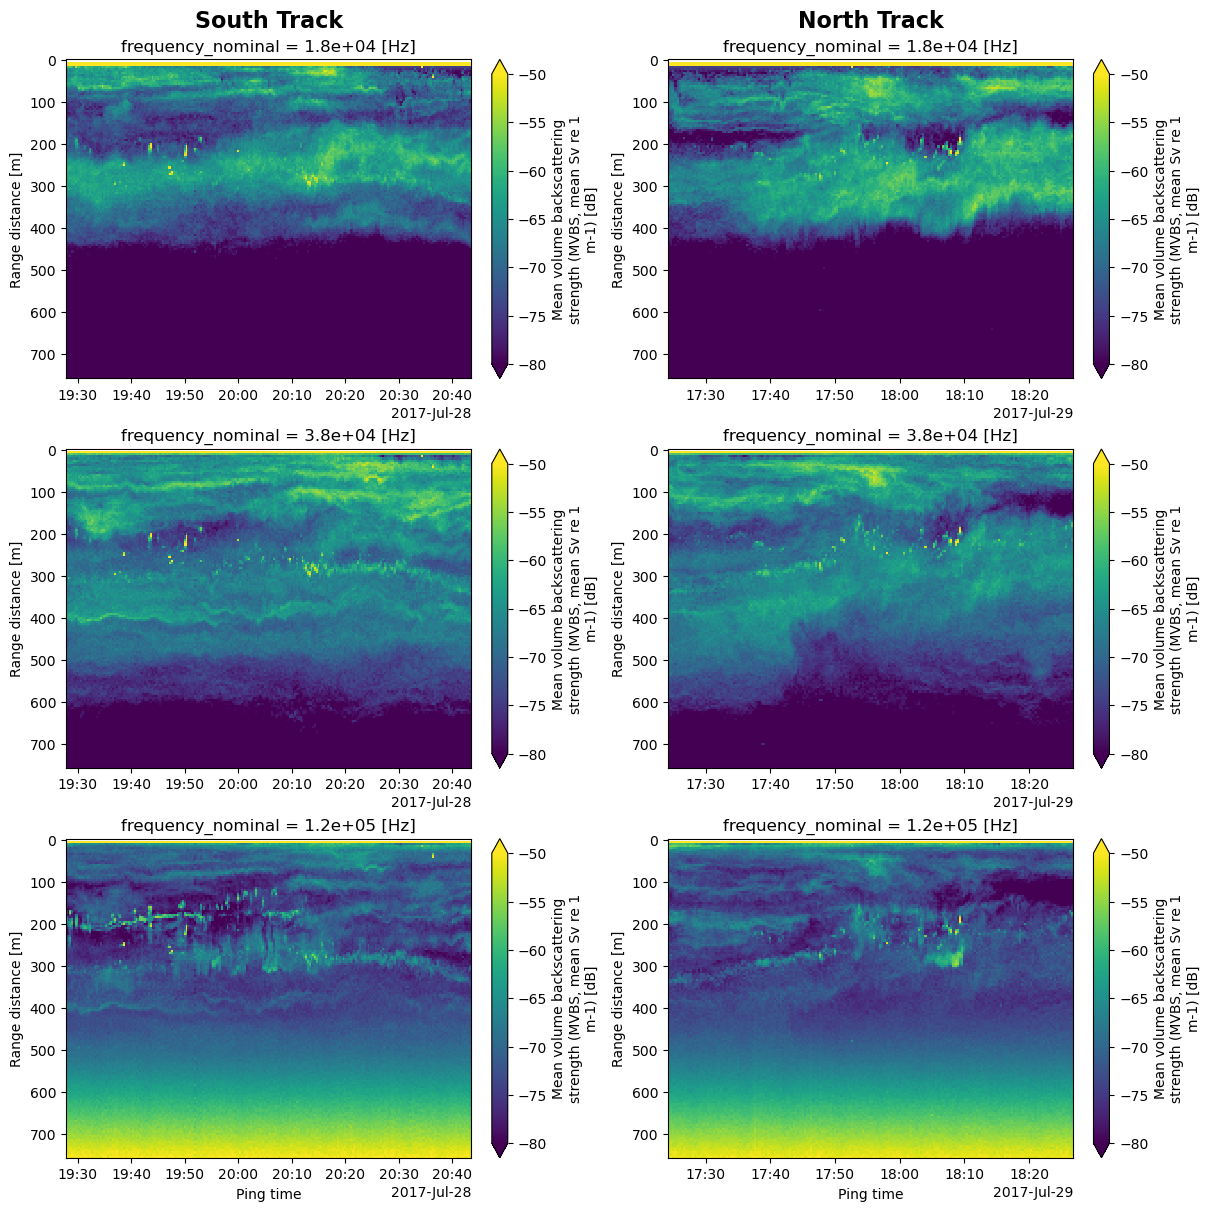

In [122]:
freq_len = ds_MVBS["frequency_nominal"].size

fig, ax = plt.subplots(freq_len, 2, constrained_layout=True, figsize=(12, 12))

for col_idx in range(2):  # left: south track, right: north track
    for freq_idx in range(freq_len):  # all frequencies
        axx = ax[freq_idx, col_idx]
        ds = ds_MVBS_south if col_idx == 0 else ds_MVBS_north
        (
            ds["Sv"]
            .isel(frequency_nominal=freq_idx)
            .plot(
                ax=axx,
                x='ping_time',
                y='depth',
                yincrease=False,
                vmin=-80, vmax=-50,
            )
        )
        if freq_idx < freq_len-1:
            axx.set_xlabel(None)

# Make titles for the two columns
ax[0, 0].text(
    0.5, 1.1, "South Track", ha="center", fontsize=16, fontweight="bold",
    transform=ax[0, 0].transAxes,  # use the axis coordinate
)
ax[0, 1].text(
    0.5, 1.1, "North Track", ha="center", fontsize=16, fontweight="bold",
    transform=ax[0, 1].transAxes,  # use the axis coordinate
)

plt.show()

## Package versions

In [123]:
import datetime, s3fs
print(f"echopype: {ep.__version__}, xarray: {xr.__version__}, geopandas: {gpd.__version__}, "
      f"fsspec: {fsspec.__version__}, s3fs: {s3fs.__version__}")

print(f"\n{datetime.datetime.utcnow()} +00:00")

echopype: 0.8.2.dev206+g743413b, xarray: 2024.6.0, geopandas: 1.0.1, fsspec: 2024.6.0, s3fs: 2024.6.0

2024-07-30 00:12:53.158303 +00:00
